In [1]:
import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available.")

# Initialize GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf

# Rutas a las carpetas de entrenamiento, prueba y validación para imágenes y máscaras
train_frames_dir = '../Frames/TRAIN'
train_Landmarks_dir = './Landmarks/TRAIN'
test_frames_dir = '../Frames/TEST'
test_Landmarks_dir = './Landmarks/TEST'
val_frames_dir = '../Frames/VAL'
val_Landmarks_dir = './Landmarks/VAL'

# Funciones para cargar y preprocesar imagen y máscara y convertirlo a solo un canal
def load_image(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0
    return image

def load_landmarks(file_path):
    images = []
    for filename in os.listdir(file_path):
        image=cv2.imread(os.path.join(file_path, filename))
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(grayscale_image)

    stacked_image = np.stack(images, axis=-1)  # axis=-1 indica la dimensión de los canales

    return stacked_image

train_image_files = [os.path.join(train_frames_dir, filename) for filename in os.listdir(train_frames_dir)]
train_Landmarks_files = [os.path.join(train_Landmarks_dir, filename) for filename in os.listdir(train_Landmarks_dir)]
test_image_files = [os.path.join(test_frames_dir, filename) for filename in os.listdir(test_frames_dir)]
test_Landmarks_files = [os.path.join(test_Landmarks_dir, filename) for filename in os.listdir(test_Landmarks_dir)]
val_image_files = [os.path.join(val_frames_dir, filename) for filename in os.listdir(val_frames_dir)]
val_Landmarks_files = [os.path.join(val_Landmarks_dir, filename) for filename in os.listdir(val_Landmarks_dir)]

train_images = [load_image(file) for file in train_image_files]
train_Landmarks = [load_landmarks(file) for file in train_Landmarks_files]

test_images = [load_image(file) for file in test_image_files]
test_Landmarks = [load_landmarks(file) for file in test_Landmarks_files]

val_images = [load_image(file) for file in val_image_files]
val_Landmarks = [load_landmarks(file) for file in val_Landmarks_files]

train_images = np.array(train_images)
train_Landmarks = np.array(train_Landmarks)
test_images = np.array(test_images)
test_Landmarks = np.array(test_Landmarks)
val_images = np.array(val_images)
val_Landmarks = np.array(val_Landmarks)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, ReLU, Conv2DTranspose

# Definición de la arquitectura U-Net
def unet_model(input_shape=(112, 112, 1)):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    conv5 = Conv2D(1024, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4])
    conv6 = Conv2D(512, 3, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    conv6 = Conv2D(512, 3, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)
    conv7 = Conv2D(256, 3, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)
    conv8 = Conv2D(128, 3, padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)
    conv9 = Conv2D(64, 3, padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)

    conv10 = Conv2D(7, 1, activation='linear')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

# Crear el modelo U-Net
model = unet_model()


In [13]:
BATCH_SIZE = 16

# with tf.device('CPU'):
#     train_dataset = tf.data.Dataset.from_tensor_slices((train_images[:700], train_Landmarks[:700]))
#     train_dataset = train_dataset.batch(BATCH_SIZE)

#     val_dataset = tf.data.Dataset.from_tensor_slices((val_images[:300], val_Landmarks[:300]))
#     val_dataset = val_dataset.batch(BATCH_SIZE)

#     test_dataset = tf.data.Dataset.from_tensor_slices((test_images[:300], test_Landmarks[:300]))
#     test_dataset = test_dataset.batch(BATCH_SIZE)

with tf.device('CPU'):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_Landmarks))
    train_dataset = train_dataset.batch(BATCH_SIZE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_Landmarks))
    val_dataset = val_dataset.batch(BATCH_SIZE)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_images[:2550], test_Landmarks[:2550]))
    test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=dice_loss, metrics=[dice_coefficient, 'accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['accuracy'])

In [15]:
# Agregamos un callback para guardar el modelo cada 5 épocas y otro para detener el entrenamiento si no hay mejora en 10 épocas
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_best_only=True, save_weights_only=True, mode='min', monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss')
]

# Entrenamos el modelo
model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
 84/933 [=>............................] - ETA: 6:21 - loss: 5.1130 - accuracy: 0.1209

KeyboardInterrupt: 

19/19 [==============================] - 3s 152ms/step


TypeError: list indices must be integers or slices, not tuple

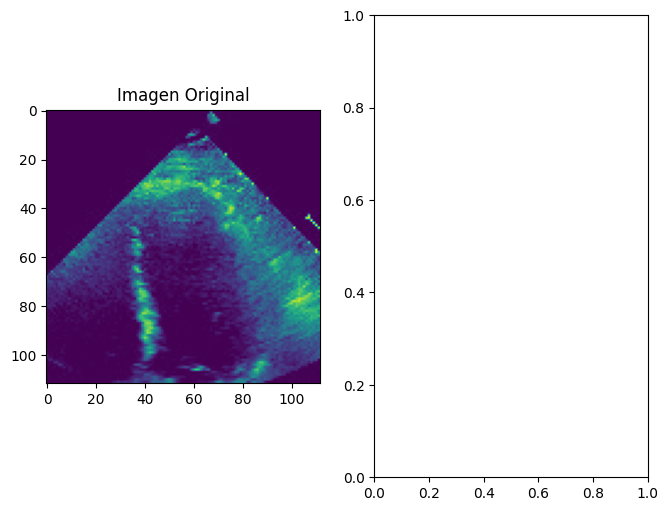

In [11]:
import matplotlib.pyplot as plt

# Función para visualizar una muestra de imágenes y sus máscaras de segmentación predichas
def visualize_segmentation(images, Landmarks, predictions):
    num_samples = len(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 6))

        # Imagen original
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Imagen Original')

        # Máscara de segmentación real (ground-truth)
        plt.subplot(1, 3, 2)
        for y in range(7):
            lm = np.stack(Landmarks[i,:,:,y], axis=-1)
        plt.imshow(lm, cmap='gray')
        plt.title('Máscara Real')

        # Máscara de segmentación predicha
        plt.subplot(1, 3, 3)
        for y in range(7):
            pr = np.stack(predictions[i,:,:,y], axis=-1)
        plt.imshow(pr, cmap='gray')
        plt.title('Máscara Predicha')

        plt.tight_layout()
        plt.show()

# Supongamos que tienes un conjunto de datos de prueba con imágenes y máscaras
# Puedes utilizar el modelo para obtener las máscaras predichas en el conjunto de prueba
predictions = model.predict(test_dataset)

# Elije algunas muestras aleatorias para visualizar
num_samples_to_visualize = 5
sample_indices = np.random.choice(len(test_images[:10]), num_samples_to_visualize, replace=False)

sample_images = [test_images[i] for i in sample_indices]
sample_Landmarks = [test_Landmarks[i] for i in sample_indices]
sample_predictions = [predictions[i] for i in sample_indices]

# Llama a la función para visualizar las imágenes y máscaras
visualize_segmentation(sample_images, sample_Landmarks, sample_predictions)